In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from research.strings import INSPECTION_ID, TARGET, PREDICTORS, OTHER_PREDICTORS
from research.evaluation import evaluate_model, show_roc, show_prc
from IPython.display import Image

In [120]:
import re
from sklearn.metrics import precision_score, recall_score, f1_score
from time import time
from datetime import datetime

def strip_comments(code):
    code = str(code)
    return re.sub(r'(?m)^ *#.*\n?', '', code)

def compute_metrics(y, pred):
    f1_val = f1_score(y, pred)
    prec_val = precision_score(y, pred)
    rec_val = recall_score(y, pred)
    return f1_val, prec_val, rec_val

def summarize(model, y_train, y_train_pred, y_test, y_test_pred, ep, src):
    f1t, pt, rt = compute_metrics(y_train, y_train_pred)
    f1v, pv, rv = compute_metrics(y_test, y_test_pred)
    s = ""
    s += datetime.now().strftime("%A %m/%d/%y %I:%M %p")
    s += "\nEpochs = {}".format(ep)
    s += "\n-----------"
    s += "\nF1(Train) = {0:.5f}".format(f1t)
    s += "\nPrecision(Train) = {0:.5f}".format(pt)
    s += "\nRecall(Train) = {0:.5f}".format(rt)
    s += "\nF1(Test) = {0:.5f}".format(f1v)
    s += "\nPrecision(Test) = {0:.5f}".format(pv)
    s += "\nRecall(Test) = {0:.5f}".format(rv)
    s += "\n-----------"
    s += "\nPredicts {0:.5f}% True on Train".format(100 * y_train_pred.sum() / len(y_train_pred))
    s += "\nPredicts {0:.5f}% True on Test".format(100 * y_test_pred.sum() / len(y_test_pred))
    s += "\n-----------\n"
    s += strip_comments(src)
    return s

def save_run(model, y_train, y_train_pred, y_test, y_test_pred, ep, src):
    s = summarize(model, y_train, y_train_pred, y_test, y_test_pred, ep, src)
    fname = "runs/model_{}.txt".format(int(time()))
    with open(fname, "w") as file:
        file.write(s + "\n")
    print("Saved run to: {}".format(fname))
    return s

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer


def get_violation_codes(report):
    if pd.isnull(report):
        return []
    else:
        codes = [int(comment.split(".")[0]) for comment in report.split(" | ")]
        return codes
        

def get_violation_level(code):
    if code <= 14:
        return "critical"
    elif code <= 29:
        return "serious"
    elif code <= 44 or code == 70:
        return "minor"
    else:
        return "unknown"

    
def get_crit_mat(df):
    code_array = [get_violation_codes(report) for report in df["violations"].values]
    crit_array = [list(filter(lambda code: get_violation_level(code) == "critical", arr)) for arr in code_array]
    crit_array = [["V" + str(i) for i in arr] for arr in crit_array]
    crit_viols = ["V" + str(i) for i in range(1, 15)]
    mlb_crit = MultiLabelBinarizer(classes=crit_viols)
    mlb_crit.fit(crit_array)
    crit_mat = pd.DataFrame(mlb_crit.transform(crit_array), columns=mlb_crit.classes_)
    return crit_mat

In [69]:
d_train = pd.read_csv("data/inspections_train.csv")
d_test = pd.read_csv("data/inspections_test.csv")
crit_train = get_crit_mat(d_train)
crit_test = get_crit_mat(d_test)
X_train = d_train[PREDICTORS]
X_test = d_test[PREDICTORS]
y_train = d_train[TARGET]
y_test = d_test[TARGET]

In [70]:
print("Features = {}, Labels = {}".format(len(X_train.columns), len(crit_train.columns)))

Features = 16, Labels = 14


In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

In [121]:
model = Sequential()
model.add(Dense(16, activation="relu", input_shape=(16,)))
# model.add(Dense(16, activation="relu"))
model.add(Dense(14, activation="sigmoid"))

In [122]:
model_source = _i

In [123]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy"
)

In [124]:
n_epochs = 10
hist = model.fit(X_train, crit_train, validation_data=(X_test, crit_test), epochs=n_epochs)

Train on 17075 samples, validate on 1637 samples
Epoch 1/10
17075/17075 [==============================] - 1s 62us/step - loss: 0.3226 - val_loss: 0.0958
Epoch 2/10
17075/17075 [==============================] - 1s 44us/step - loss: 0.0832 - val_loss: 0.0788
Epoch 3/10
17075/17075 [==============================] - 1s 43us/step - loss: 0.0764 - val_loss: 0.0745
Epoch 4/10
17075/17075 [==============================] - 1s 44us/step - loss: 0.0732 - val_loss: 0.0710
Epoch 5/10
17075/17075 [==============================] - 1s 43us/step - loss: 0.0703 - val_loss: 0.0699
Epoch 6/10
17075/17075 [==============================] - 1s 44us/step - loss: 0.0682 - val_loss: 0.0703
Epoch 7/10
17075/17075 [==============================] - 1s 43us/step - loss: 0.0669 - val_loss: 0.0694
Epoch 8/10
17075/17075 [==============================] - 1s 43us/step - loss: 0.0659 - val_loss: 0.0704
Epoch 9/10
17075/17075 [==============================] - 1s 44us/step - loss: 0.0649 - val_loss: 0.0684
Epoch 

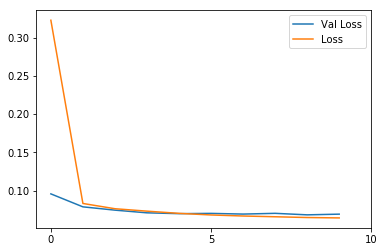

In [125]:
sns.lineplot(x=range(n_epochs), y=hist.history["val_loss"], label="Val Loss")
sns.lineplot(x=range(n_epochs), y=hist.history["loss"], label="Loss")
plt.xticks(range(0, n_epochs + 1, 5))
plt.show()

In [126]:
y_train_pred = (model.predict(X_train).max(axis=1) >= 0.5).astype(int)
y_test_pred = (model.predict(X_test).max(axis=1) >= 0.5).astype(int)
s = save_run(model, y_train, y_train_pred, y_test, y_test_pred, n_epochs, model_source)
print(s)

Saved run to: runs/model_1552172036.txt
Saturday 03/09/19 04:53 PM
Epochs = 10
-----------
F1(Train) = 0.03288
Precision(Train) = 0.44565
Recall(Train) = 0.01707
F1(Test) = 0.08602
Precision(Test) = 0.57143
Recall(Test) = 0.04651
-----------
Predicts 0.53880% True on Train
Predicts 1.28283% True on Test
-----------
model = Sequential()
model.add(Dense(16, activation="relu", input_shape=(16,)))
model.add(Dense(14, activation="sigmoid"))


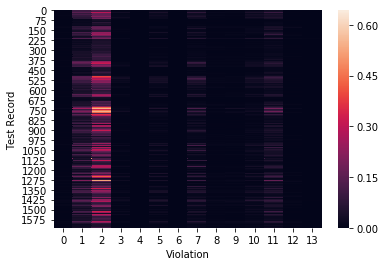

In [127]:
sns.heatmap(model.predict(X_test))
plt.xlabel("Violation")
plt.ylabel("Test Record")
plt.show()